# Heuristic Code

In [1]:
!./pybind_compile.sh

In [2]:
import numpy as np
from regression import regression as find_subset

# Computes the linear regression loss when regressing the vector b against A.
def lin_reg(A, b):
    temp = np.transpose(A) @ b
    return np.dot(b, b) - np.dot(temp, np.linalg.inv(np.transpose(A) @ A) @ temp)

## Orthogonal Matching Pursuit

In [3]:
# A simple greedy algorithm for subset selection.
def omp(A, b, k):
    n = A.shape[1]
    A = A.copy()
    b = b.copy()
    T = []
    bests = []
    for t in range(k):
        best = -1
        best_obj = None
        
        for i in range(n):
            if np.linalg.norm(A[:,i]) < 1e-5:
                continue
            obj = np.dot(b, A[:,i]) / np.linalg.norm(A[:,i])
            if best_obj is None or obj > best_obj:
                best = i
                best_obj = obj 
                
        T.append(best)
        best_vec = A[:, best].copy() / np.linalg.norm(A[:,best])
        for i in range(n):
            A[:,i] -= np.dot(best_vec, A[:,i]) * best_vec
        b -= np.dot(best_vec, b) * best_vec
        bests.append(np.linalg.norm(b)**2)
    return T, bests

# Test Code

In [19]:
import time
def hyp_test(A, b, k_min, k_max):
    hyp_scores = dict()
    hyp_timings = dict()
    for i in range(k_min, k_max):
        start_time = time.time()
        T = find_subset(A,b,i)
        end_time = time.time()
        hyp_timings[i] = end_time - start_time
        hyp_scores[i] = lin_reg(A[:,T], b)        
    return hyp_scores, hyp_timings

def omp_test(A, b, k_min, k_max):
    omp_scores = dict()
    omp_timings = dict()
    for i in range(k_min, k_max):
        start_time = time.time()
        T, bests = omp(A,b,i)
        end_time = time.time()
        omp_timings[i] = end_time - start_time
        omp_scores[i] = lin_reg(A[:,T], b)
    return omp_scores, omp_timings

from sklearn import linear_model
def lasso_test(A, b, threshold, alphas, k_min, k_max, use_threshold=False):
    # Set the starting scores to be something larger than what we would expect
    lasso_scores = {k : None for k in range(k_min, k_max)}
    lasso_timings = dict()
    for alpha in alphas:
        # Use exponentially decreasing values of alpha to get different sizes of support
        clf = linear_model.Lasso(alpha=alpha, max_iter=10000000)
        start_time = time.time()
        clf.fit(A,b)
        end_time = time.time()
        if use_threshold:
            T = [i for i,x in enumerate(clf.coef_) if abs(x) >= threshold]
            k = len(T)
            if k < k_min or k >= k_max:
                continue
            score = lin_reg(A[:,T], b)
            if lasso_scores[k] is None  or lasso_scores[k] > score:
                lasso_scores[k] = score
                lasso_timings[k] = end_time - start_time
        else:
            coeffs = sorted(list(enumerate(clf.coef_)), key=lambda x: -abs(x[1]))
            ranking = [x[0] for x in coeffs]
            for k in range(k_min, k_max):
                T = ranking[:k]
                score = lin_reg(A[:,T], b)
                if lasso_scores[k] is None or score < lasso_scores[k]:
                    lasso_timings[k] = end_time - start_time
                    lasso_scores[k] = score
    return lasso_scores, lasso_timings

import matplotlib.pyplot as plt

def plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max):
    # plot lasso
    if lasso_scores is not None:
        lasso_xs = [k for k in range(k_min, k_max) if lasso_scores[k] is not None]
        lasso_ys = [lasso_scores[k] for k in lasso_xs]
        plt.plot(lasso_xs, lasso_ys, label="Lasso")

    # plot hyp
    if hyp_scores is not None:
        hyp_xs = list(range(k_min, k_max))
        hyp_ys = [hyp_scores[k] for k in hyp_xs]
        plt.plot(hyp_xs, hyp_ys, label="Greedy Cond")

    # plot omp|
    if omp_scores is not None:
        omp_xs = list(range(k_min, k_max))
        omp_ys = [omp_scores[k] for k in omp_xs]
        plt.plot(omp_xs, omp_ys, label="omp")
    
    plt.xticks(list(range(k_min,k_max)))
    plt.xlabel("k")
    plt.ylabel("L2 Error")

    plt.legend()
    plt.show()

# Superconductivity Example

In [24]:
import pandas as pd
df = pd.read_csv("../sparse_qcqp_code/data/superconduct.csv", delimiter=",")
df = (df - df.mean())/df.std()
A = df.to_numpy()

b = A[:,-1]
A = A[:,:-1]
k_min = 2
k_max = 20
A_copy = A.copy()
hyp_scores, hyp_timings = hyp_test(A_copy, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.1 ** (t-65) for t in range(50)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

# Violent Crime

In [22]:
import pandas as pd
df = pd.read_csv("../sparse_qcqp_code/data/CommViolPredUnnormalizedData.txt", delimiter=",")
# Only take interesting columns
df = df.iloc[:,5:-17].replace("?", None).dropna(axis=1)
df = (df - df.mean())/df.std()
A = df.to_numpy()
b = A[:,-1]
A = A[:,:-1]

k_min = 3
k_max = 20
hyp_scores, hyp_timings = hyp_test(A, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.1 ** (t-65) for t in range(10)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

# Sklearn Diabetes Data

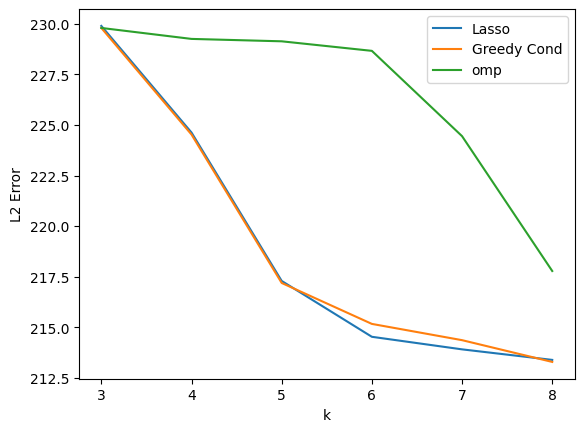

[[3, 6.842613220214844e-05, 0.0003838539123535156, 0.0006589889526367188], [4, 5.9604644775390625e-05, 0.00048232078552246094, 0.0006589889526367188], [5, 6.651878356933594e-05, 0.0005872249603271484, 0.0003230571746826172], [6, 7.700920104980469e-05, 0.0006971359252929688, 0.0008504390716552734], [7, 8.296966552734375e-05, 0.0007779598236083984, 0.0008504390716552734], [8, 0.00013828277587890625, 0.0008695125579833984, 0.0008504390716552734]]


In [28]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
A = diabetes["data"]
for col in range(len(A[0])):
    A[:, col] -= np.mean(A[:,col])
    A[:, col] /= np.std(A[:,col])
b = diabetes["target"]
b -= np.mean(b)
b /= np.std(b)

k_min = 3
k_max = 9
hyp_scores, hyp_timings = hyp_test(A, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.1 ** (t-65) for t in range(100)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, {x:lasso_scores[x]+0.1 for x in lasso_scores}, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

# Wine Dataset

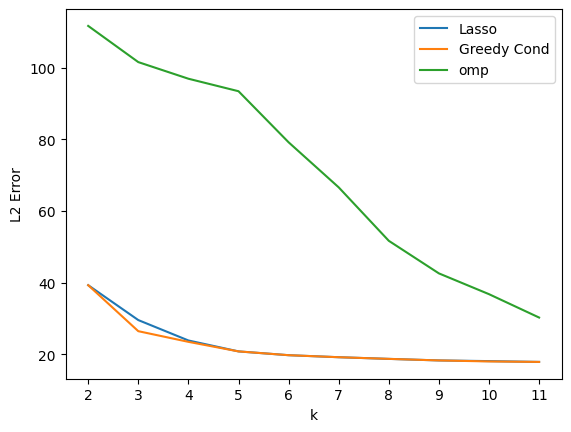

[[2, 7.271766662597656e-05, 0.0003554821014404297, 0.00047588348388671875], [3, 7.176399230957031e-05, 0.0004286766052246094, 0.0002524852752685547], [4, 8.440017700195312e-05, 0.0005648136138916016, 0.00047588348388671875], [5, 9.918212890625e-05, 0.0007038116455078125, 0.00047588348388671875], [6, 0.00011992454528808594, 0.0008864402770996094, 0.00047588348388671875], [7, 0.00012564659118652344, 0.0009438991546630859, 0.00047588348388671875], [8, 0.0001385211944580078, 0.0010383129119873047, 0.00027370452880859375], [9, 0.00015163421630859375, 0.001142263412475586, 0.00027370452880859375], [10, 0.00016188621520996094, 0.0012593269348144531, 0.00047588348388671875], [11, 0.0001811981201171875, 0.0013477802276611328, 0.0002720355987548828]]


In [30]:
from sklearn.datasets import load_wine
wine = load_wine()
A = wine["data"].astype(float)
b = wine["target"].astype(float)
for col in range(len(A[0])):
    A[:, col] -= np.mean(A[:,col])
    A[:, col] /= np.std(A[:,col])
b -= np.mean(b)
b /= np.std(b)

k_min = 2
k_max = 12
hyp_scores, hyp_timings = hyp_test(A, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.05 ** (t-400) for t in range(500)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

# Regression with random matrices

In [17]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.02)
import random
def test(n,m,k):
    T = random.sample(list(range(n)), k)
    T.sort()
    print("T: ", T)
    A = np.random.normal(loc = 0, scale = 1, size = (m,n))
    b = sum(A[:,i] for i in T)
    S1 = find_subset(A, b, k)
    print("characteristic: ", S1)
    S1.sort()
    s1 = all(s == t for t, s in zip(T, S1))
    lasso = clf.fit(A, b).coef_
    S2 = [a[1] for a in sorted([(-abs(x),i) for i,x in enumerate(lasso)])[:k]]
    S2.sort()
    s2 = all(s == t for t, s in zip(T, S2))
    S3, scores3 = omp(A,b,k)
    print("omp: ", S3)
    S3.sort()
    s3 = all(s == t for t, s in zip(T, S3))
    norm_b = np.linalg.norm(b)
    return (s1,s2,s3)

In [18]:
n = 100
m = 30
iters = 10
count_dict = []
for k in range(6,25):
    counts = [0,0,0]
    for i in range(iters):
        for i, result in enumerate(test(n,m,k)):
            if result:
                counts[i] += 1
    print(counts)
    count_dict.append(counts)
print(count_dict)

T:  [31, 59, 67, 68, 71, 89]
characteristic:  [89, 74, 34, 91, 79, 95]
omp:  [89, 74, 38, 12, 72, 63]
T:  [14, 25, 31, 36, 68, 70]
characteristic:  [36, 68, 31, 25, 70, 14]
omp:  [36, 68, 31, 25, 70, 14]
T:  [18, 29, 31, 71, 74, 85]
characteristic:  [74, 18, 31, 85, 29, 71]
omp:  [74, 18, 31, 85, 29, 71]
T:  [9, 16, 18, 31, 75, 84]
characteristic:  [18, 31, 84, 60, 4, 63]
omp:  [18, 84, 31, 60, 4, 63]
T:  [12, 50, 52, 74, 77, 94]
characteristic:  [50, 75, 68, 74, 40, 52]
omp:  [50, 75, 68, 74, 35, 12]
T:  [5, 26, 34, 43, 57, 95]
characteristic:  [34, 5, 82, 57, 20, 2]
omp:  [95, 34, 5, 82, 57, 43]
T:  [7, 14, 15, 26, 77, 96]
characteristic:  [14, 77, 96, 7, 26, 15]
omp:  [14, 77, 96, 7, 26, 15]
T:  [18, 23, 26, 64, 67, 77]
characteristic:  [77, 64, 26, 23, 18, 67]
omp:  [77, 64, 26, 23, 18, 67]
T:  [13, 23, 28, 29, 50, 90]
characteristic:  [23, 13, 34, 76, 25, 4]
omp:  [23, 13, 29, 28, 90, 50]
T:  [17, 18, 43, 45, 76, 90]
characteristic:  [43, 18, 17, 76, 45, 90]
omp:  [43, 18, 17, 76,

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.294e-02, tolerance: 2.621e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.555e-02, tolerance: 2.532e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [53, 99, 90, 15, 54, 70, 66, 88]
T:  [17, 26, 28, 33, 48, 59, 79, 97]
characteristic:  [59, 28, 1, 41, 48, 26, 81, 69]
omp:  [59, 28, 1, 41, 48, 26, 81, 96]
T:  [2, 4, 5, 24, 30, 70, 82, 97]
characteristic:  [4, 83, 43, 42, 7, 80, 44, 97]
omp:  [4, 83, 43, 69, 97, 70, 44, 80]
T:  [14, 16, 45, 67, 75, 78, 84, 97]
characteristic:  [60, 30, 75, 78, 32, 95, 94, 33]
omp:  [97, 57, 75, 78, 84, 14, 16, 67]
T:  [26, 31, 59, 64, 65, 67, 70, 91]
characteristic:  [64, 59, 67, 70, 31, 26, 65, 91]
omp:  [64, 59, 67, 70, 31, 26, 65, 91]
[2, 7, 3]
T:  [14, 23, 28, 36, 41, 52, 62, 91, 93]
characteristic:  [14, 83, 73, 24, 88, 49, 16, 63, 90]
omp:  [14, 41, 62, 36, 93, 23, 28, 91, 52]
T:  [8, 26, 37, 50, 60, 64, 87, 90, 96]
characteristic:  [26, 60, 75, 87, 64, 37, 80, 48, 52]
omp:  [26, 60, 75, 87, 64, 37, 80, 48, 90]
T:  [2, 5, 7, 12, 24, 32, 64, 70, 81]
characteristic:  [24, 21, 33, 4, 96, 93, 19, 64, 68]
omp:  [24, 12, 32, 62, 58, 64, 7, 90, 98]
T:  [6, 7, 8, 25, 34, 47, 49, 69, 82]
character

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.511e-02, tolerance: 2.226e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.284e-02, tolerance: 2.776e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [98, 29, 83, 30, 69, 88, 68, 55, 81, 56, 6]
T:  [8, 10, 11, 12, 13, 43, 49, 55, 56, 60, 88]
characteristic:  [94, 17, 38, 8, 57, 60, 11, 88, 65, 22, 43]
omp:  [49, 96, 13, 10, 12, 8, 56, 55, 60, 46, 43]
T:  [1, 15, 18, 21, 33, 35, 45, 47, 56, 77, 81]
characteristic:  [33, 81, 77, 21, 80, 65, 13, 97, 75, 6, 92]
omp:  [33, 81, 77, 21, 60, 59, 6, 18, 91, 2, 70]
T:  [6, 9, 18, 24, 41, 47, 51, 63, 71, 72, 87]
characteristic:  [6, 47, 86, 18, 13, 43, 83, 67, 78, 35, 2]
omp:  [47, 6, 86, 18, 13, 17, 48, 71, 51, 35, 89]
T:  [18, 27, 29, 37, 43, 60, 64, 68, 72, 81, 84]
characteristic:  [64, 31, 60, 27, 17, 14, 53, 21, 33, 41, 67]
omp:  [60, 31, 64, 27, 18, 37, 43, 2, 72, 84, 68]
T:  [14, 23, 26, 29, 30, 49, 63, 66, 68, 72, 77]
characteristic:  [30, 49, 72, 66, 68, 36, 56, 78, 19, 61, 32]
omp:  [30, 49, 72, 68, 66, 36, 32, 29, 23, 78, 14]
T:  [8, 11, 12, 13, 23, 53, 57, 59, 62, 64, 69]
characteristic:  [24, 14, 70, 95, 58, 19, 77, 22, 26, 72, 98]
omp:  [24, 23, 8, 62, 11, 53, 21, 64, 59, 2

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.455e-02, tolerance: 2.730e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.024e-02, tolerance: 2.795e-02
  model = cd_fast.enet_coordinate_descent(


characteristic:  [44, 58, 27, 80, 26, 38, 77, 86, 42, 50, 9, 62]
omp:  [44, 58, 38, 26, 80, 94, 53, 71, 31, 56, 49, 34]
T:  [2, 10, 12, 18, 19, 26, 35, 37, 45, 57, 77, 90]
characteristic:  [57, 45, 94, 70, 2, 88, 80, 98, 37, 26, 48, 15]
omp:  [57, 45, 58, 73, 35, 94, 90, 70, 2, 26, 64, 42]
T:  [7, 11, 25, 26, 33, 35, 36, 44, 77, 82, 85, 87]
characteristic:  [33, 11, 99, 50, 44, 7, 85, 32, 12, 97, 1, 90]
omp:  [33, 11, 85, 7, 36, 25, 44, 35, 87, 26, 77, 82]
T:  [11, 16, 28, 36, 41, 43, 72, 77, 82, 91, 94, 99]
characteristic:  [16, 99, 94, 43, 11, 20, 14, 55, 68, 51, 84, 81]
omp:  [11, 16, 28, 94, 18, 99, 73, 45, 8, 41, 89, 1]
T:  [7, 21, 22, 33, 45, 54, 72, 83, 84, 93, 96, 98]
characteristic:  [15, 22, 73, 64, 99, 25, 84, 45, 92, 16, 32, 62]
omp:  [45, 99, 84, 22, 21, 26, 0, 83, 29, 25, 48, 93]
T:  [4, 5, 6, 8, 15, 28, 32, 44, 46, 53, 74, 77]
characteristic:  [5, 4, 58, 32, 99, 69, 51, 41, 31, 29, 92, 6]
omp:  [5, 40, 4, 58, 32, 14, 44, 51, 76, 15, 28, 99]
T:  [11, 22, 28, 31, 38, 41, 4

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.132e-02, tolerance: 5.252e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [45, 25, 13, 65, 32, 46, 8, 53, 4, 75, 22, 40, 71]
T:  [4, 11, 25, 34, 42, 43, 47, 50, 53, 54, 75, 87, 89]
characteristic:  [75, 74, 47, 34, 66, 13, 3, 4, 79, 41, 78, 98, 12]
omp:  [75, 74, 34, 66, 54, 28, 26, 47, 4, 53, 39, 91, 63]
T:  [2, 7, 26, 28, 29, 56, 66, 68, 69, 70, 78, 88, 92]
characteristic:  [70, 7, 2, 92, 57, 53, 9, 42, 63, 5, 8, 86, 0]
omp:  [70, 43, 8, 2, 92, 44, 61, 71, 53, 49, 26, 88, 68]
T:  [2, 6, 21, 26, 27, 47, 72, 74, 77, 82, 84, 85, 90]
characteristic:  [42, 77, 44, 47, 34, 60, 98, 9, 96, 92, 22, 61, 45]
omp:  [42, 77, 44, 47, 86, 74, 5, 36, 66, 78, 51, 6, 13]
T:  [7, 17, 26, 32, 34, 40, 46, 63, 67, 69, 94, 96, 97]
characteristic:  [69, 72, 85, 49, 57, 26, 14, 50, 89, 46, 38, 13, 67]
omp:  [69, 72, 85, 49, 48, 41, 32, 89, 5, 34, 29, 91, 96]
[0, 2, 0]
T:  [2, 7, 8, 21, 30, 31, 40, 42, 51, 58, 73, 79, 92, 93]
characteristic:  [98, 65, 45, 66, 79, 59, 35, 8, 15, 30, 84, 61, 97, 9]
omp:  [65, 50, 45, 12, 40, 82, 93, 19, 78, 30, 54, 94, 34, 51]
T:  [0, 8, 15, 19

characteristic:  [17, 80, 47, 22, 23, 54, 84, 36, 97, 21, 2, 52, 30, 87, 44, 53, 0]
omp:  [17, 80, 47, 22, 23, 54, 53, 79, 31, 86, 52, 18, 85, 97, 7, 91, 59]
T:  [12, 14, 19, 23, 31, 32, 36, 50, 52, 54, 69, 70, 80, 81, 84, 85, 95]
characteristic:  [23, 25, 29, 99, 48, 62, 27, 6, 55, 71, 41, 13, 4, 90, 3, 2, 38]
omp:  [23, 25, 50, 0, 52, 31, 79, 12, 80, 90, 81, 95, 46, 70, 94, 18, 65]
T:  [4, 5, 6, 25, 27, 32, 35, 41, 47, 59, 69, 71, 79, 85, 86, 88, 92]
characteristic:  [47, 13, 73, 15, 81, 78, 63, 37, 16, 84, 18, 72, 1, 12, 8, 59, 98]
omp:  [47, 13, 73, 21, 81, 27, 9, 15, 32, 86, 75, 54, 65, 37, 43, 52, 91]
[0, 0, 0]
T:  [6, 14, 24, 32, 33, 39, 45, 54, 55, 57, 58, 65, 69, 74, 79, 84, 89, 92]
characteristic:  [84, 39, 18, 33, 99, 62, 93, 74, 87, 96, 46, 12, 17, 52, 94, 57, 56, 49]
omp:  [84, 58, 33, 99, 14, 65, 19, 92, 39, 74, 46, 29, 79, 20, 77, 82, 2, 42]
T:  [0, 1, 9, 12, 13, 17, 21, 24, 39, 42, 44, 53, 59, 61, 69, 73, 88, 95]
characteristic:  [73, 59, 95, 47, 32, 31, 40, 57, 79, 38,

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.232e-02, tolerance: 5.064e-02
  model = cd_fast.enet_coordinate_descent(


characteristic:  [97, 40, 10, 80, 21, 27, 50, 6, 71, 5, 52, 84, 70, 4, 20, 74, 94, 48]
omp:  [97, 10, 40, 92, 74, 71, 27, 14, 13, 87, 12, 20, 64, 53, 57, 98, 30, 78]
T:  [0, 5, 6, 18, 24, 27, 33, 36, 48, 50, 68, 72, 82, 84, 86, 90, 92, 98]
characteristic:  [92, 18, 15, 19, 78, 88, 90, 1, 36, 49, 5, 22, 62, 71, 58, 54, 51, 97]
omp:  [92, 18, 65, 95, 58, 94, 93, 57, 48, 36, 46, 5, 28, 71, 54, 42, 24, 74]
T:  [10, 11, 24, 30, 35, 39, 46, 59, 60, 71, 75, 78, 79, 82, 85, 86, 96, 98]
characteristic:  [85, 50, 4, 43, 83, 33, 61, 62, 45, 46, 27, 60, 80, 3, 17, 64, 11, 47]
omp:  [85, 82, 24, 78, 9, 4, 86, 35, 30, 84, 75, 39, 56, 67, 79, 11, 12, 41]
T:  [2, 4, 15, 19, 24, 44, 45, 46, 49, 53, 60, 64, 75, 85, 87, 88, 91, 98]
characteristic:  [4, 85, 72, 66, 64, 46, 69, 75, 1, 39, 68, 19, 35, 97, 76, 9, 15, 20]
omp:  [4, 85, 72, 21, 87, 64, 45, 9, 28, 59, 49, 69, 88, 77, 57, 47, 92, 75]
T:  [0, 7, 14, 15, 24, 28, 41, 43, 50, 54, 64, 71, 72, 80, 84, 86, 91, 96]
characteristic:  [84, 50, 0, 27, 72, 2

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.074e-01, tolerance: 4.991e-02
  model = cd_fast.enet_coordinate_descent(


characteristic:  [84, 17, 65, 62, 23, 99, 34, 69, 4, 30, 53, 58, 37, 75, 18, 12, 31, 51]
omp:  [84, 17, 65, 54, 41, 22, 69, 47, 39, 44, 1, 38, 13, 55, 53, 57, 40, 8]
T:  [9, 16, 23, 40, 41, 42, 44, 52, 56, 59, 61, 63, 65, 67, 79, 88, 90, 91]
characteristic:  [95, 91, 65, 88, 11, 19, 30, 89, 29, 28, 13, 41, 24, 4, 40, 64, 43, 37]
omp:  [65, 91, 88, 23, 67, 92, 40, 24, 63, 1, 51, 5, 52, 10, 48, 43, 16, 37]
T:  [3, 4, 12, 13, 40, 46, 50, 56, 60, 67, 70, 79, 84, 89, 90, 94, 95, 97]
characteristic:  [13, 33, 37, 99, 56, 26, 18, 14, 97, 43, 76, 73, 72, 79, 52, 65, 66, 9]
omp:  [13, 83, 56, 14, 79, 4, 84, 40, 90, 3, 54, 1, 89, 63, 57, 62, 97, 71]
[0, 0, 0]
T:  [6, 8, 12, 16, 18, 24, 31, 33, 38, 41, 43, 73, 77, 79, 80, 82, 84, 89, 91]
characteristic:  [37, 24, 33, 12, 89, 41, 95, 9, 99, 8, 10, 73, 14, 79, 84, 7, 44, 59, 94]
omp:  [16, 33, 24, 12, 89, 37, 39, 7, 11, 41, 4, 23, 74, 34, 69, 80, 82, 32, 88]
T:  [5, 9, 11, 15, 22, 32, 47, 49, 61, 62, 63, 68, 69, 78, 79, 89, 92, 96, 98]
characterist

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.072e-01, tolerance: 4.697e-02
  model = cd_fast.enet_coordinate_descent(


characteristic:  [17, 11, 15, 7, 48, 42, 54, 99, 60, 49, 91, 85, 58, 84, 43, 88, 74, 73, 5, 19]
omp:  [88, 69, 91, 20, 10, 19, 13, 68, 11, 31, 18, 89, 17, 47, 34, 54, 7, 35, 15, 32]
T:  [7, 8, 11, 14, 21, 23, 24, 25, 28, 29, 48, 50, 55, 56, 58, 62, 68, 74, 75, 94]
characteristic:  [50, 11, 94, 64, 51, 81, 13, 7, 98, 93, 89, 0, 45, 74, 71, 39, 5, 40, 18, 57]
omp:  [48, 50, 11, 94, 29, 36, 56, 25, 78, 39, 58, 74, 54, 38, 67, 7, 23, 5, 66, 64]
T:  [9, 17, 25, 27, 33, 34, 39, 61, 62, 66, 70, 71, 74, 75, 77, 81, 87, 88, 93, 94]
characteristic:  [74, 17, 62, 39, 72, 59, 36, 79, 41, 87, 24, 32, 20, 0, 2, 26, 67, 35, 68, 93]
omp:  [62, 17, 74, 39, 33, 72, 3, 9, 41, 84, 20, 87, 16, 85, 71, 98, 68, 22, 15, 65]
T:  [2, 3, 10, 14, 15, 21, 22, 35, 43, 46, 49, 57, 70, 82, 86, 89, 92, 93, 94, 98]
characteristic:  [21, 46, 35, 70, 17, 56, 94, 19, 83, 30, 33, 1, 69, 52, 23, 59, 31, 18, 92, 75]
omp:  [35, 46, 70, 52, 94, 3, 19, 92, 55, 56, 14, 2, 21, 57, 97, 16, 10, 98, 5, 54]
T:  [12, 18, 33, 34, 39, 4

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.404e-01, tolerance: 8.557e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [33, 17, 34, 21, 51, 43, 56, 41, 39, 60, 94, 93, 25, 58, 42, 14, 64, 53, 75, 2]
T:  [9, 14, 15, 23, 24, 29, 31, 34, 43, 49, 54, 55, 57, 65, 72, 77, 80, 85, 86, 91]
characteristic:  [75, 71, 45, 36, 29, 68, 86, 69, 97, 14, 59, 35, 93, 9, 88, 21, 1, 33, 39, 56]
omp:  [86, 15, 77, 57, 49, 29, 80, 35, 4, 24, 65, 81, 52, 9, 72, 44, 10, 8, 41, 76]
T:  [6, 9, 17, 19, 22, 24, 29, 46, 47, 52, 53, 54, 61, 65, 67, 70, 72, 79, 87, 89]
characteristic:  [2, 19, 38, 51, 85, 10, 64, 63, 5, 70, 59, 74, 36, 47, 26, 18, 50, 40, 33, 9]
omp:  [72, 76, 70, 19, 40, 52, 36, 7, 85, 9, 67, 65, 0, 12, 61, 53, 96, 77, 79, 90]
T:  [2, 10, 12, 14, 16, 17, 24, 27, 34, 46, 53, 54, 58, 63, 71, 76, 82, 85, 94, 97]
characteristic:  [8, 42, 93, 38, 91, 69, 45, 81, 5, 65, 76, 25, 68, 6, 75, 87, 62, 21, 63, 30]
omp:  [54, 94, 76, 53, 38, 71, 17, 90, 97, 28, 44, 16, 10, 74, 31, 6, 43, 56, 96, 20]
[0, 0, 0]
T:  [3, 7, 13, 15, 17, 26, 29, 34, 38, 43, 45, 69, 70, 71, 74, 77, 85, 86, 87, 88, 95]
characteristic:  [38, 88, 

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.263e-02, tolerance: 4.263e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [15, 64, 85, 5, 0, 39, 93, 56, 86, 71, 6, 76, 75, 4, 81, 96, 43, 52, 50, 89, 45]
T:  [7, 22, 30, 31, 32, 34, 35, 39, 40, 45, 47, 53, 56, 59, 61, 62, 65, 66, 68, 79, 95]
characteristic:  [45, 16, 35, 29, 87, 94, 39, 51, 19, 1, 11, 59, 69, 40, 25, 72, 80, 58, 14, 12, 41]
omp:  [45, 16, 35, 19, 22, 95, 31, 58, 53, 69, 30, 3, 33, 96, 2, 39, 24, 68, 87, 86, 32]
T:  [7, 12, 15, 23, 27, 28, 45, 49, 56, 58, 59, 64, 68, 70, 75, 83, 85, 87, 90, 94, 98]
characteristic:  [12, 23, 85, 2, 7, 15, 47, 44, 87, 30, 96, 43, 93, 78, 1, 82, 39, 50, 72, 14, 3]
omp:  [64, 12, 23, 58, 75, 70, 49, 38, 30, 87, 13, 92, 65, 91, 81, 15, 21, 99, 0, 11, 60]
T:  [2, 11, 13, 15, 18, 21, 29, 35, 38, 39, 42, 45, 49, 51, 56, 61, 76, 80, 84, 98, 99]
characteristic:  [49, 42, 11, 45, 64, 4, 44, 14, 31, 69, 25, 16, 91, 15, 70, 57, 1, 37, 93, 0, 68]
omp:  [23, 42, 0, 76, 2, 49, 45, 11, 4, 35, 55, 39, 32, 91, 92, 53, 25, 56, 94, 1, 8]
T:  [8, 16, 21, 24, 26, 30, 32, 40, 41, 42, 62, 64, 65, 69, 81, 82, 91, 92, 93, 94, 98

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e-01, tolerance: 6.613e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.006e-02, tolerance: 6.159e-02
  model = cd_fast.enet_coordinate_descent(


characteristic:  [62, 80, 26, 5, 36, 21, 10, 20, 63, 8, 1, 14, 81, 22, 90, 19, 76, 61, 12, 49, 9, 13]
omp:  [10, 36, 76, 50, 6, 71, 66, 1, 55, 0, 63, 51, 20, 65, 54, 53, 58, 67, 35, 87, 77, 46]
T:  [1, 6, 9, 10, 21, 27, 29, 32, 37, 39, 42, 49, 52, 68, 70, 71, 80, 81, 84, 87, 91, 98]
characteristic:  [81, 32, 9, 51, 65, 16, 61, 28, 18, 91, 74, 6, 72, 29, 4, 52, 83, 43, 24, 94, 58, 71]
omp:  [81, 9, 32, 80, 49, 52, 71, 42, 40, 3, 53, 24, 10, 95, 11, 46, 72, 94, 44, 15, 45, 41]
T:  [4, 8, 9, 10, 11, 16, 18, 33, 34, 37, 40, 46, 50, 52, 58, 62, 64, 69, 81, 85, 86, 90]
characteristic:  [54, 46, 95, 41, 43, 38, 8, 21, 80, 25, 77, 15, 22, 13, 9, 87, 10, 14, 61, 84, 33, 11]
omp:  [87, 52, 8, 37, 46, 34, 78, 90, 22, 69, 85, 50, 18, 4, 62, 51, 76, 3, 93, 38, 12, 89]
T:  [0, 1, 3, 4, 6, 9, 11, 19, 20, 26, 27, 37, 41, 49, 51, 72, 80, 81, 84, 88, 89, 91]
characteristic:  [45, 81, 0, 22, 19, 74, 31, 64, 94, 90, 49, 37, 6, 27, 14, 5, 60, 77, 51, 41, 91, 21]
omp:  [0, 45, 81, 40, 22, 6, 10, 26, 11, 71,

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.952e-02, tolerance: 3.562e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [12, 28, 65, 32, 51, 76, 26, 57, 40, 72, 31, 11, 69, 53, 3, 59, 14, 64, 84, 97, 44, 17]
T:  [1, 9, 13, 25, 29, 42, 45, 50, 51, 54, 55, 59, 62, 64, 65, 66, 74, 77, 85, 86, 87, 97]
characteristic:  [13, 2, 59, 88, 54, 55, 5, 39, 86, 76, 8, 3, 45, 20, 30, 46, 44, 80, 95, 34, 94, 48]
omp:  [2, 55, 33, 13, 59, 53, 65, 86, 87, 89, 91, 97, 48, 54, 79, 58, 46, 67, 25, 81, 49, 39]
[0, 0, 0]
T:  [7, 10, 17, 20, 21, 25, 28, 30, 57, 60, 61, 63, 65, 66, 67, 70, 71, 76, 85, 86, 92, 93, 97]
characteristic:  [59, 21, 63, 40, 28, 65, 57, 0, 67, 37, 61, 52, 9, 80, 74, 12, 89, 50, 64, 60, 45, 55, 95]
omp:  [59, 21, 63, 40, 28, 98, 65, 20, 3, 82, 57, 55, 0, 61, 36, 84, 30, 4, 26, 9, 11, 96, 67]
T:  [4, 10, 18, 24, 34, 35, 38, 49, 62, 64, 66, 72, 73, 76, 78, 81, 83, 86, 87, 90, 91, 93, 99]
characteristic:  [38, 10, 4, 93, 49, 79, 25, 54, 83, 84, 97, 91, 98, 71, 2, 95, 60, 94, 52, 82, 62, 61, 65]
omp:  [38, 10, 4, 93, 25, 79, 49, 12, 65, 55, 27, 97, 2, 76, 72, 64, 91, 56, 21, 83, 90, 45, 87]
T:  [6, 1

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.575e-02, tolerance: 6.013e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e-01, tolerance: 7.875e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [27, 65, 53, 39, 12, 95, 69, 3, 71, 92, 43, 98, 60, 97, 37, 29, 26, 81, 54, 48, 64, 74, 1]
T:  [7, 13, 19, 23, 26, 34, 35, 40, 41, 44, 46, 48, 59, 61, 64, 68, 71, 86, 89, 93, 95, 97, 99]
characteristic:  [23, 63, 87, 68, 13, 7, 84, 62, 27, 95, 24, 56, 60, 19, 39, 79, 22, 15, 8, 64, 54, 65, 46]
omp:  [4, 95, 89, 23, 40, 63, 70, 20, 99, 57, 27, 97, 41, 67, 8, 28, 18, 14, 72, 24, 74, 94, 22]
T:  [2, 11, 12, 29, 35, 39, 43, 44, 53, 54, 55, 57, 59, 62, 70, 72, 77, 80, 81, 82, 87, 92, 96]
characteristic:  [54, 65, 2, 82, 86, 39, 4, 70, 6, 63, 1, 96, 50, 8, 61, 47, 88, 30, 59, 5, 99, 38, 14]
omp:  [92, 2, 80, 54, 59, 81, 77, 50, 72, 39, 82, 90, 12, 52, 45, 0, 93, 99, 17, 67, 22, 18, 53]
T:  [2, 13, 19, 23, 28, 30, 35, 42, 43, 47, 50, 53, 54, 55, 68, 69, 70, 75, 76, 86, 87, 94, 99]
characteristic:  [54, 13, 61, 47, 76, 92, 20, 4, 83, 53, 51, 17, 67, 39, 72, 14, 10, 82, 71, 64, 70, 96, 89]
omp:  [54, 13, 47, 61, 76, 92, 20, 4, 43, 86, 34, 1, 27, 19, 69, 94, 29, 33, 70, 44, 80, 93, 2]
T:  

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.720e-01, tolerance: 6.927e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e-01, tolerance: 6.815e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [54, 57, 43, 78, 90, 79, 24, 76, 96, 12, 8, 5, 27, 7, 82, 81, 34, 25, 89, 18, 21, 38, 40]
T:  [7, 9, 10, 26, 31, 33, 35, 40, 41, 44, 46, 54, 59, 61, 64, 71, 73, 75, 82, 83, 84, 85, 93]
characteristic:  [64, 41, 59, 45, 43, 83, 14, 70, 1, 19, 75, 42, 31, 3, 82, 18, 30, 60, 35, 4, 38, 34, 9]
omp:  [64, 31, 74, 21, 13, 46, 83, 92, 85, 56, 45, 59, 78, 26, 33, 9, 19, 73, 71, 47, 24, 52, 3]
T:  [1, 3, 8, 10, 11, 16, 18, 19, 23, 25, 28, 40, 41, 46, 47, 48, 52, 55, 67, 70, 80, 91, 93]
characteristic:  [28, 93, 82, 48, 36, 70, 59, 27, 34, 0, 31, 68, 20, 13, 80, 37, 97, 69, 95, 63, 51, 92, 50]
omp:  [28, 93, 82, 48, 80, 16, 72, 11, 83, 38, 36, 50, 8, 27, 44, 20, 52, 70, 41, 79, 19, 49, 76]
T:  [0, 2, 6, 8, 13, 14, 15, 23, 26, 36, 40, 43, 46, 47, 59, 68, 69, 71, 77, 78, 83, 97, 99]
characteristic:  [54, 83, 40, 94, 87, 61, 7, 81, 16, 13, 0, 23, 78, 27, 42, 79, 92, 15, 31, 34, 4, 39, 6]
omp:  [83, 13, 87, 54, 71, 36, 78, 68, 93, 82, 45, 19, 53, 10, 77, 24, 95, 52, 40, 55, 66, 21, 76]
[0, 0, 

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.899e-01, tolerance: 8.279e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.145e-02, tolerance: 6.529e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [7, 24, 55, 62, 92, 77, 2, 10, 66, 34, 79, 69, 3, 51, 87, 4, 52, 21, 80, 58, 39, 23, 22, 81]
T:  [6, 11, 16, 28, 34, 35, 36, 41, 47, 49, 50, 54, 55, 61, 63, 64, 65, 69, 70, 79, 84, 86, 96, 99]
characteristic:  [84, 35, 63, 17, 68, 34, 51, 64, 76, 14, 30, 99, 74, 53, 22, 59, 7, 45, 6, 41, 27, 61, 26, 3]
omp:  [84, 86, 35, 96, 55, 79, 90, 63, 50, 81, 34, 69, 24, 28, 68, 16, 70, 56, 65, 21, 93, 2, 47, 19]
T:  [1, 5, 11, 12, 16, 37, 39, 44, 45, 50, 51, 53, 69, 70, 71, 72, 73, 74, 75, 83, 88, 92, 95, 98]
characteristic:  [72, 7, 70, 33, 31, 16, 65, 2, 34, 54, 25, 3, 57, 17, 63, 51, 87, 19, 36, 15, 81, 86, 92, 8]
omp:  [72, 60, 38, 3, 0, 57, 25, 30, 74, 95, 44, 43, 98, 56, 82, 13, 17, 6, 73, 1, 99, 63, 36, 93]
T:  [0, 17, 19, 24, 26, 29, 33, 41, 43, 45, 47, 53, 54, 57, 59, 66, 70, 71, 80, 81, 87, 91, 97, 98]
characteristic:  [33, 84, 30, 78, 45, 39, 4, 61, 51, 79, 46, 52, 15, 92, 65, 3, 43, 58, 37, 63, 60, 75, 82, 40]
omp:  [84, 33, 71, 45, 66, 20, 24, 16, 87, 90, 46, 12, 15, 37, 69, 9

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.079e-01, tolerance: 6.277e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e-01, tolerance: 1.436e-01
  model = cd_fast.enet_coordinate_descent(


omp:  [22, 34, 91, 1, 36, 77, 38, 74, 7, 46, 60, 52, 0, 26, 65, 47, 66, 70, 28, 86, 76, 12, 21, 20]
T:  [2, 7, 9, 24, 26, 36, 39, 40, 42, 45, 49, 50, 53, 65, 66, 67, 69, 70, 72, 74, 84, 86, 96, 97]
characteristic:  [74, 92, 41, 70, 79, 12, 94, 80, 17, 24, 37, 44, 87, 73, 53, 67, 86, 29, 1, 82, 75, 45, 48, 19]
omp:  [36, 92, 74, 79, 65, 53, 40, 97, 93, 8, 26, 70, 81, 19, 76, 22, 50, 17, 91, 48, 29, 49, 78, 16]
T:  [5, 13, 18, 20, 21, 29, 36, 37, 40, 41, 49, 51, 56, 58, 63, 65, 82, 83, 84, 87, 88, 90, 95, 96]
characteristic:  [13, 95, 44, 18, 64, 32, 49, 85, 67, 57, 77, 69, 19, 94, 92, 70, 31, 22, 51, 59, 55, 66, 38, 40]
omp:  [13, 58, 21, 68, 49, 88, 40, 71, 96, 19, 87, 84, 59, 64, 45, 78, 4, 80, 93, 22, 98, 67, 89, 14]
T:  [0, 3, 8, 15, 18, 22, 23, 24, 25, 32, 36, 40, 43, 53, 58, 64, 65, 67, 74, 77, 83, 88, 89, 94]
characteristic:  [64, 88, 38, 61, 59, 27, 21, 81, 17, 6, 97, 62, 91, 93, 49, 13, 36, 37, 66, 65, 60, 4, 63, 56]
omp:  [64, 88, 61, 65, 75, 87, 23, 77, 69, 10, 3, 71, 25, 2, 

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.474e-01, tolerance: 8.473e-02
  model = cd_fast.enet_coordinate_descent(
